<!-- <p align="center">
    <img src="https://drive.google.com/uc?id=1X5bFPfUK4EcVgD39XGUgLjtQCpyxYJOS" width="1600px" height="320px">
</p> -->
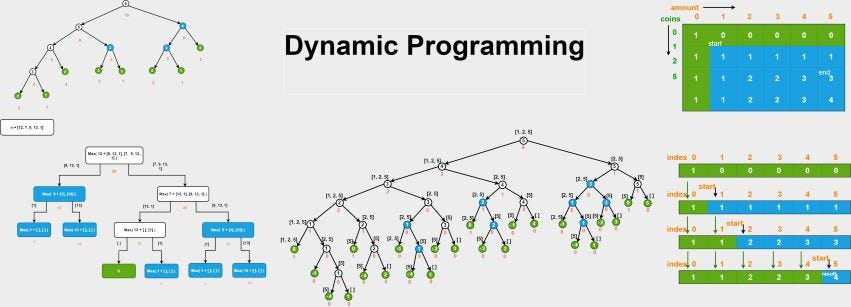


#0 - Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#I. Maintenance problem
<!-- **Description du problème**

Nous considérons une entreprise qui exploite de nombreux distributeurs automatiques. Ils sont changés tous les ans (12 mois). Un distributeur peut être neuf, en bon état, vieux ou cassé. Chaque mois, il peut soit ne rien faire (coût 0), soit entretenir (coût 10), soit réparer (coût 15 si la machine est en bon état, 30 si elle est vieille, 50 si elle est cassée), soit remplacer (coût 70) une machine. Une machine réparée sera en bon état à la fin du mois. A
machine remplacée sera neuve à la fin du mois. Aucune action ne peut être entreprise sur une machine neuve et elle sera en bon état à la fin du mois. Sans maintenance (resp. avec maintenance), une machine en bon état sera en bon état à la fin du mois avec une probabilité de 0,3 (resp. 0,8) et vieille avec une probabilité de 0,7 (resp. 0,2). Sans maintenance (resp. avec maintenance), une machine en mauvais état sera en mauvais état à la fin du mois avec une probabilité de 0,5 (resp. 0,9) et en panne avec une probabilité de 0,5 (resp. 0,1).

Une machine en panne restera en panne à moins d'être réparée ou remplacée. Une machine neuve rapporte 30, une machine en bon état rapporte 20, une vieille machine rapporte 10 et une machine cassée rapporte 0 pour le mois. -->

The approach is based on modeling in the form of a controlled Markov chain.

**Question 1.a**

The machines are replaced every **12 months** (lifespan) so it is necessary to calculate the **Total Cost** (revenue - costs) over twelve months in order to take it into account. Thus, the Total Cost function is the **algebraic sum** over 12 months of production revenues and operational costs (different maintenance actions).

Under the assumption that the industry owns a large number of machines (which is often the case), the company is interested in the **average gain** of its N machines: $\bar{Z_N}=\frac{1}{N}\displaystyle\sum_{n=0}^{N}Z_n$ with $Z_n$ representing the total gain of machine n.

It can also be assumed that the machines are independent and identical. Thus, $(Z_n)_n$ are **IID and integrable as they are bounded**.

→ According to the strong law of large numbers, $\bar{Z_N}$ converges almost surely towards $\mathbb{E}(Z_1)$.

Thus, the cost function of the problem is $\mathbb{E}[\displaystyle\sum_{t=1}^{12} G(X_t)-C(a_t,X_t)]$ with $X_t$ the state of the machine at time $t$, $a_t$ the control at time $t$, G the gain, and C the transition cost.

**Question 1.b: Modeling the Problem**

Thus, the optimization problem can be described using controlled Markov chains:

$
\max_{a=(a_t)_t} \mathbb{E}[\displaystyle\sum_{t=1}^{12} G(X_t)-C(a_t,X_t)]\\
\begin{equation}
\begin{aligned}
\textrm{s.t.}
  & \quad \mathbb{P}(X_{t+1}=y | X_t=x,\,a_t=a)=P^a(x,y)\\
\end{aligned}
\end{equation}
$

with $P^a$ being the state transition matrix described in the statement (which are indeed stochastic). \\
By adopting the convention of ordering the states as: New, Good shape, Old shape, Broken.

$
P^{donothing} =  \begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & 0.3 & 0.7 & 0 \\
0 & 0 & 0.5 & 0.5 \\
0 & 0 & 0 & 1
\end{bmatrix}, P^{maintain} =  \begin{bmatrix}
0 & 1 & 0 & 0 \\
0.5 & 0.3 & 0.2 & 0 \\
0 & 0 & 0.9 & 0.1 \\
0 & 0 & 0 & 1
\end{bmatrix}  $


$P^{replace} =  \begin{bmatrix}
1 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 \\
1 & 0 & 0 & 0
\end{bmatrix},
P^{repair} =  \begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix}
$

<!-- **Question 1.b : Modélisation du problème**

Ainsi, le problème d'optimisation peut être décrit avec des chaînes de Markov contrôlées:

$
\max_{a=(a_t)_t} \mathbb{E}[\displaystyle\sum_{t=1}^{12} G(X_t)-C(a_t,X_t)]\\
\begin{equation}
\begin{aligned}
\textrm{s.t.}
  & \quad \mathbb{P}(X_{t+1}=y | X_t=x,\,a_t=a)=P^a(x,y)\\
\end{aligned}
\end{equation}
$

avec $P^a$ la matrice de transition des états décrite dans l'énoncé (qui sont bien stochastiques). \\
En adoptant la convention d'ordonner les états : new, good shape, old shape, broken -->

**Question 1.c : Solving the problem with dynamic programming**

### Structures

In [ ]:
Action = range(4)   # 0 : nothing  /  1 : maintain  /  2 : repair  /  3 : replace

# indices of states: 0->New / 1->Good / 2->Old / 3->Broken
P_nothing = np.array([[0,1,0,0], [0,0.3,0.7,0], [0,0,0.5,0.5], [0,0,0,1]] )
P_maintain = np.array([[0,1,0,0], [0,0.8,0.2,0], [0,0,0.9,0.1], [0,0,0,1]])
P_repair = np.array([[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0]])
P_replace = np.array([[1,0,0,0],[1,0,0,0],[1,0,0,0],[1,0,0,0]])

#Couts+rewards (une ligne = une action ; une colonne = un état) ; c'est la fonction C_t(x_t,a_t)
Costs = np.array([30,20,10,0])[None, :] - np.array([[0]*4, [10]*4, [5,15,30,50], [70]*4])   #le 5 dans la 2e liste est ajouté par nous.

#Initialisation des Val[11,:]
V = np.zeros((12,4))         #ligne = pas de temps  /  colonne = état
V[11,:] = np.array([30,20,10,0])
Actions = np.zeros((11,4), dtype="int")

###Algorithm

The code handles python indexing that starts from 0. So let's be careful to when we use indices and when we use natural values (indice+1).

In [ ]:
for t in range(10, -1, -1):   #t= 10, 9, ..., 0
    Aux = np.array([V[t+1,0], V[t+1,1], V[t+1,2], V[t+1,3]])    # V_t+1(N) , V_t+1(G), V_t+1(O), V_t+1(B)

    Values_N = Costs[:,0] + np.array([ np.dot(Aux,P_nothing[0,:]), np.dot(Aux,P_maintain[0,:]), np.dot(Aux,P_repair[0,:]), np.dot(Aux,P_replace[0,:])])
    V[t,0] = np.max( Values_N )    #New
    Actions[t,0] = np.argmax( Values_N )

    Values_G = Costs[:,1] + np.array([ np.dot(Aux,P_nothing[1,:]), np.dot(Aux,P_maintain[1,:]), np.dot(Aux,P_repair[1,:]), np.dot(Aux,P_replace[1,:])])
    V[t,1] = np.max( Values_G )    #Good Shape
    Actions[t,1] = np.argmax( Values_G )

    Values_O = Costs[:,2] + np.array([ np.dot(Aux,P_nothing[2,:]), np.dot(Aux,P_maintain[2,:]), np.dot(Aux,P_repair[2,:]), np.dot(Aux,P_replace[2,:])])
    V[t,2] = np.max( Values_O )    #Old
    Actions[t,2] = np.argmax( Values_O )

    Values_B = Costs[:,3] + np.array([ np.dot(Aux,P_nothing[3,:]), np.dot(Aux,P_maintain[3,:]), np.dot(Aux,P_repair[3,:]), np.dot(Aux,P_replace[3,:])])
    V[t,3] = np.max( Values_B )    #Broken
    Actions[t,3] = np.argmax( Values_B )

print(f"The optimal value (gain) of the problem: {V[0,0]:.2f}")    #Starting with a New machine

The optimal value (gain) of the problem: 110.82


In [ ]:
# Reconstruction de la Policy Optimale
for t in range(11):
    # print les actions dans chaque mois
    actions_names = ['Nothing', 'Maintain', 'Repair', 'Replace']
    opt_actions = [actions_names[i] for i in Actions[t, :]]   #Actions Optimales en fct des états
    print(f"A la fin du {t}e mois / début du {t+1}e, les actions optimales sont { opt_actions } respectivement pour les états {['New', 'Good', 'Old', 'Broken']}\n")

A la fin du 0e mois / début du 1e, les actions optimales sont ['Nothing', 'Maintain', 'Repair', 'Replace'] respectivement pour les états ['New', 'Good', 'Old', 'Broken']

A la fin du 1e mois / début du 2e, les actions optimales sont ['Nothing', 'Maintain', 'Repair', 'Replace'] respectivement pour les états ['New', 'Good', 'Old', 'Broken']

A la fin du 2e mois / début du 3e, les actions optimales sont ['Nothing', 'Maintain', 'Repair', 'Replace'] respectivement pour les états ['New', 'Good', 'Old', 'Broken']

A la fin du 3e mois / début du 4e, les actions optimales sont ['Nothing', 'Maintain', 'Repair', 'Replace'] respectivement pour les états ['New', 'Good', 'Old', 'Broken']

A la fin du 4e mois / début du 5e, les actions optimales sont ['Nothing', 'Maintain', 'Repair', 'Replace'] respectivement pour les états ['New', 'Good', 'Old', 'Broken']

A la fin du 5e mois / début du 6e, les actions optimales sont ['Nothing', 'Maintain', 'Repair', 'Replace'] respectivement pour les états ['New', 

**Description**: <br>
 - Usually repair is the optimal action for an old machine.
 - Usually maintain is the optimal decision for a Good machine → it increases chances of keeping its good shape.
 - The 2 last months, it's optimal to **do nothing**. Indeed, there is no enough time to recover the operational costs if other actions are taken.

# II. Stock Management
The approach is based on a modeling in the form of a Markov controlled system.

#### **Question 2.a: Modeling the Problem**:

The problem is formulated as follows:


$
\begin{equation}
\min_{\pi=(\pi_t)_t} \quad  \mathbb{E}[\displaystyle\sum_{t=1}^{T=14}\overbrace{0.1x_{t+1}}^{\text{storage cost}}+\overbrace{1u_t}^{\text{production cost}}-\overbrace{3v_t}^{\text{sales revenue}}] \\
\begin{aligned}
\textrm{s.t.}
  & \quad x_{t+1}=x_t + u_t - v_{t}\\
  & \quad v_{t}=\text{min}(x_t-1, d_{t}); \text{(**)} \\
  & \quad u_t=\pi_t(x_t) \text{ ; <=> }u_t \in\sigma(d_1,...,d_t)  \\
  & \quad x_1=10 \\
  & \quad 1\leq x_t \leq 20\\
  & \quad 0\leq u_t \leq 5 \\
  & \quad d_t \text{~} B(n,p_t)
\end{aligned}
\end{equation}
$
<br>


The state of the system is given by $x_t$, which represents **the available stock on the morning of day $t$** (stored the previous night). \\
The control of the problem is $u_t$ and represents the production (**order**) **on the evening of day $t$**. ( * ) \\
Thus, $x_t + u_t - v_t$ represents **the quantity of product available for sale on day $t+1$**, which is the remainder from day t and hence the stock $x_{t+1}$.


The dynamics of stock variation are:
$
\underbrace{x_{t+1}}_{\text{quantity available for sale on day t+1}}=\underbrace{x_t+u_t}_{\text{quantity available in the morning + provided/ordered in the evening (t)}}-\underbrace{v_{t}}_{\text{quantity sold during day t}}
$

The goal is always to sell the maximum possible quantity without exceeding the demand or depleting the stock. Therefore, the sale is defined by:
$v_{t}=\text{min}(x_t-1,d_{t})$
<br>
<br>
*Remarks* : <br>
- ( * ) In our approach, the order $u_t$ is placed **and received** at the end of day t **(immediate)**! <br>
→ Therefore, we expect **a result** (~ 111) **optimally lower** than in the case where **the order arrives the next morning** (~117). <br>
- In our approach, we introduce the stock $x_{T+1}$ (the evening of the last day T) and allow it to be zero. <br>
Previously, all stocks are of course in [1,20].
- We have **forbidden a sale = $x_t$**. To prevent $x_{t+1}$ from possibly being 0 (see **( ** )** in the code). <br>

<!-- #### **Question 2.a : Modélisation du problème**:
Le problème s'écrit sous la forme :
$
\begin{equation}
\min_{\pi=(\pi_t)_t} \quad  \mathbb{E}[\displaystyle\sum_{t=1}^{T=14}\overbrace{0,1x_{t+1}}^{\text{coût de stockage}}+\overbrace{1u_t}^{\text{coût de production}}-\overbrace{3v_t}^{\text{gain de vente}}] \\
\begin{aligned}
\textrm{s.t.}
  & \quad x_{t+1}=x_t + u_t - v_{t}\\
  & \quad v_{t}=\text{min }(x_t-1 , d_{t}); \ (**) \\
  & \quad u_t=\pi_t(x_t) \text{ ; <=> }u_t \in\sigma(d_1,...,d_t)  \\
  & \quad x_1=10 \\
  & \quad 1\leq x_t \leq 20\\
  & \quad 0\leq u_t \leq 5 \\
  & \quad d_t \text{~} B(n,p_t)
\end{aligned}
\end{equation}
$
<br>


L'état du système est donné par $x_t$ qui représente **le stock dispo le matin du jour $t$** (stocké la veille). \\
Le contrôle du problème est $u_t$ et représente **la production** (commande) **le soir du jour $t$**. ( * ) \\
Ainsi, $x_t + u_t - v_t$ représente **la quantité de produit disponible pour la vente du le jour $t+1$**, soit le reste du jour t et donc le stock $x_{t+1}$.


La dynamique de la variation de stock est :
$
\underbrace{x_{t+1}}_{\text{quantité dispo pour la vente le jour t+1}}=\underbrace{x_t+u_t}_{\text{quantité dispo le matin + produite le soir (t)}}-\underbrace{v_{t}}_{\text{quantité vendue durant la journée t}}
$

On cherche toujours à vendre la quantité maximale possible sans pourtant dépasser la demande, ni annuler le stock. Donc la vente est définie par :
$v_{t}=\text{min }(x_t-1,d_{t})$
<br>
<br>
*Remarques* : <br>
- ( * ) Dans notre approche, la commande $u_t$ est passée **et reçue** à la fin de la journée t **(immédiate)** ! <br>
→ On s'attendra donc à **un résultat** (\~111) **optimal moins élevé** que dans le cas ou **la commande arrive le lendemain matin**(\~117). <br>
- Dans notre approche, on introduit le stock $x_{T+1}$ (le soir du dernier jour T) et on se permet de l'avoir nul. <br>
Avant, tous les stocks sont bien sûr dans [1,20].
- Nous avons **interdit une vente = $x_t$**. Pour éviter que $x_{t+1}$ puisse valoir 0 (cf. **( ** )** dans le code). <br> -->

**Question 2.b : Bellman Equation** <br>
$V_t[x_t] = min_{a_t \in [0,5]}(V_{ t+1}[x_{t+1}^{a_t,x_t}] )$, where $x_{t+1}$ is computed by $x_t$, $a_t$ and $d_t$ defined in the dynamics above.


**Question 2.c**

A strategy $\pi$ is a collection of policies $\pi_t$, a function that starts from $\mathcal{X}=[\![1;20]\!]$ the set of states to $\mathcal{A}=[\![0;5]\!]$ the set of actions which corresponds to the production order.

Indeed, the actions $u_t$ are random variables measurable by the demands, but as the noises (coming from the demands) are independent, the states **contain all the information about the past of the demands**. → hence the policy described above.


In [15]:
#Question (2c) :
n, T = 10, 14
p = np.array([0.2,0.2,0.4,0.4,0.7,0.7,0.2,0.2,0.8,0.8,0.5,0.5,0.2,0.2])

def simulate_D(T):
    '''Returns a realization of T demands in a list'''
    D = []
    for t in range(T):
        d_t = np.random.binomial(n, p[t%14])
        D.append(d_t)
    return D

def simulator(policy, M=20000, T=14, Verbose=True):
    '''Returns the Expected Cost given a Policy, a maximum number of simulations M and a time horizon T.'''
    Simul_Costs = []

    for i in range(M):
        D = simulate_D(T)      #demand list
        X = [10]   #List of states xt (stocks)
        U, V=[], [] # U : orders ut ;  V : sales vt

        for t in range(T):             #Get u(t) with policy --> Get x(t+1) with the dynamics...
            xt = X[-1]                 #the last stock (of this morning)
            vt = min(xt-1 , D[t])        #sale (vente)    (**)
            V.append(vt)
            ut = policy[t, xt - 1]     #Action / the xt - 1 is for the python indexing
            U.append(ut)
            xt_1 = xt + ut - vt         # x(t+1) = x(t) + u(t) - v(t)
            X.append(xt_1)

        # calcul de la somme (coût)
        Cout = np.sum( 0.1*(np.array(X)[1:]) + np.array(U) - 3*np.array(V) )
        Simul_Costs.append(Cout)

    expect = np.mean(Simul_Costs)
    std_error = 1.96*np.std(Simul_Costs)/np.sqrt(M)
    formatted_conf_interval = [f"{val:.2f}" for val in [-expect-std_error, -expect+std_error]]
    print(f"For {M} simulations, the confidence interval is {formatted_conf_interval}") if Verbose else None
    return expect

**Note**: In the code (Python), the states (stock $x_t$) given as an argument to the policy function range from 0 to 19. An $x_t$ that equals i in the code corresponds to a real stock of (i+1) due to Python indexing.


In [16]:
# Q(2d)
def heuristic_policy(T, demand=5):
    '''
    Retourne une policy heuristique (Indép du temps)
    avec l'hypothèse que la demande est tjs constante (égale à 5 par défaut).
    On commande afin d'avoir xt=demand le lendemain matin.
    '''
    policy = np.zeros((T,20), dtype="int")   # shape = (time x states)
    for state_ind in range(20):
        state = state_ind + 1   #python trick
        #sous l'hyp sur la demande (Cst), ce qu'il faut commander le soir pour avoir d=demand demain matin:
        policy[:T-1, state_ind] = np.repeat( max( demand - max(0,state-demand),  0 ) , T-1 )
    return policy

h_policy = heuristic_policy(T)
h_Cost = simulator(h_policy)
print(f"For this Heuristic Policy (based on a constant demand of 5), we have a total cost of {h_Cost: .2f}. Which means a Revenue of{-h_Cost: .2f}.\n")
print(f"Among 0, 1, 2, 3, 4 and 5, this heuristic gives its best result with a constant demand of 5.\n4 gives also a relatively good revenue.\n \nA hypothetically constant demand of 1 for example, gives less revenue (only{-simulator(heuristic_policy(T, 1), M=20000, Verbose=False): .2f}). \nWhich is logical given the real demand law B(10,pt).")

For 20000 simulations, the confidence interval is ['86.57', '86.81']
For this Heuristic Policy (based on a constant demand of 5), we have a total cost of -86.69. Which means a Revenue of 86.69.

Among 0, 1, 2, 3, 4 and 5, this heuristic gives its best result with a constant demand of 5.
4 gives also a relatively good revenue.
 
A hypothetically constant demand of 1 for example, gives less revenue (only 33.23). 
Which is logical given the real demand law B(10,pt).


In [5]:
# Question (2e)
T = 14
from scipy.stats import binom

def Exp_cost(Costs, p):
    '''
    Args : Costs (array of costs, for d=k in [0,10]), p parameter of the binomial demand.
    Returns the expected cost for a demand d ~ B(n,p)
    '''
    K = np.arange(11)
    probas = binom.pmf(K, 10, p)     # list of P(d=k)
    return np.sum(probas*Costs)      # expectation

def Q_values_xt(t, xt, Val, T):
    '''
    Returns the 6 Q values associated to actions u(t) in [0,5].
    +infinity for potentially impossible actions (that can give a stock >20)
    '''
    true_xt = xt + 1   #python indexing
    Vt = np.array( [min(dt, true_xt-1) for dt in range(11)], dtype="int" )   # Sales for all dt values (**)
    Xt = np.array([true_xt]*11, dtype="int")    # useful afterwards
    Q  = np.array([float("inf")]*6)  # Q_values (initialized as +infinity)

    for ut in range(6):
        Ut = np.array([ut]*11, dtype="int")
        X_tplus1 = Xt-Vt+Ut

        if t==T-1:                              #If it's the last day, there should be no order ==> Q values for ut!=0 should be +infinity.
            Q_array = 0.1*X_tplus1 + Ut - 3*Vt
            Q[0] = Exp_cost(Q_array, p[t%14])    #t%14 ensures the periodic demand if T>14
            return Q

        else:
            Values_tplus1 = np.array([ Val[ t+1, X_tplus1[d]-1 ] if 0<X_tplus1[d]<21 else float("inf") for d in range(11) ])         # List of Values V[t+1, x(t+1)] when dt varies in [0,10] / infinity if x(t+1) isn't allowed

            Q_array = Values_tplus1 + 0.1*X_tplus1 + Ut - 3*Vt
            Q[ut] = Exp_cost(Q_array, p[t%14])                                     # Q[ut] given that d ~ B(10,p[t])
    return Q


def Prog_dyn(T=14):
    '''Returns the optimal policy found with Dynamic Programming'''
    V, policy = np.zeros((T,20)), np.zeros((T,20), dtype="int")     # Values,

    for t in range(T-1, -1, -1):   #t : 13, 12, 11, ..., 1, 0  (+1)
        for xt in range(20):       #true_stock = stock_ind + 1
            if t==0 and xt!=9:
                V[t, xt] = float("inf")                    #We start with x1 = 10 --> other x1 values don't make sense
                continue
            else:
                V[t, xt] = np.min(Q_values_xt(t, xt, V, T))   # Start by filling Values for the last day.
                policy[t, xt] = np.argmin(Q_values_xt(t, xt, V, T))
    return V[0,9], policy, V

Opt_Cost, Opt_Policy, V = Prog_dyn()    #Run the Dynamic Programming

In [6]:
def print_policy(policy):    #shows a policy given its matrix
    format_string = "{:<2}->{:<8}"
    action_map = {0: 'No order', 1: 'Order 1', 2: 'Order 2', 3: 'Order 3', 4: 'Order 4', 5: 'Order 5'}
    policy_strings = np.array([[action_map[action] for action in row] for row in policy])

    for t, row in enumerate(policy_strings):
        print(f"\nDay {t+1:<2}: ", end="")
        if t==0:
            print(f'10->{row[9]}')
            continue
        for x, action in enumerate(row):
            print(format_string.format(x+1, action), end="")
            if x < len(row)-1:
                print(", ", end="")
        print()

print("Recall that here, orders are done at the end of each day and received the same day (immediately). The optimal policy is:")
print_policy(Opt_Policy)    #check if it's logical
print(f"\nThe optimal revenue is: {- Opt_Cost:.2f}.")

Recall that here, orders are done at the end of each day and received the same day. The optimal policy is:

Day 1 : 10->Order 1

Day 2 : 1 ->Order 5 , 2 ->Order 5 , 3 ->Order 5 , 4 ->Order 5 , 5 ->Order 5 , 6 ->Order 5 , 7 ->Order 5 , 8 ->Order 5 , 9 ->Order 5 , 10->Order 4 , 11->Order 3 , 12->Order 2 , 13->Order 1 , 14->No order, 15->No order, 16->No order, 17->No order, 18->No order, 19->No order, 20->No order

Day 3 : 1 ->Order 5 , 2 ->Order 5 , 3 ->Order 5 , 4 ->Order 5 , 5 ->Order 5 , 6 ->Order 5 , 7 ->Order 5 , 8 ->Order 5 , 9 ->Order 5 , 10->Order 5 , 11->Order 5 , 12->Order 5 , 13->Order 4 , 14->Order 3 , 15->Order 2 , 16->Order 1 , 17->No order, 18->No order, 19->No order, 20->No order

Day 4 : 1 ->Order 5 , 2 ->Order 5 , 3 ->Order 5 , 4 ->Order 5 , 5 ->Order 5 , 6 ->Order 5 , 7 ->Order 5 , 8 ->Order 5 , 9 ->Order 5 , 10->Order 5 , 11->Order 5 , 12->Order 5 , 13->Order 5 , 14->Order 4 , 15->Order 3 , 16->Order 2 , 17->Order 1 , 18->No order, 19->No order, 20->No order

Day 5 :

**Description**:
- The most occurent optimal action is to order 5. Especially in early days. This may be interpreted by the relatively low costs of stocking and ordering compared to the revenue of selling. Given the limitation on the maximum order (5) and the constraint of stocking at least 1 product, this motivates high orders in the first 3 quarters of the period in order to provide for those days and last ones too.
- In the last 3 days, it isn't the case as we would have already provided stock for these days and we won't risk buying many new products that won't be selled.

In [18]:
# Question (2)(f)
simul_opt_cost = simulator(Opt_Policy, Verbose=True)
print(f"The simulated optimal revenue equals: {- simul_opt_cost:.2f}.")
print(f"Do we find the same optimal value (±0.5% error)? \n--> {'YES :)' if np.isclose(Opt_Cost, simul_opt_cost, rtol=0.005) else 'NO :('}")

For 20000 simulations, the confidence interval is ['111.78', '112.04']
The simulated optimal revenue equals: 111.91.
Do we find the same optimal value (±0.5% error)? 
--> YES :)


In [23]:
# Question (3)(a)
Opt_Cost3, Opt_Policy3, V3 = Prog_dyn(T=96)   #Solving
print(f"The new optimal revenue is: {- Opt_Cost3:.2f}.\n")    #Optimal Value
print(f"Now let's simulate and check:")
simul_opt_cost3 = simulator(Opt_Policy3, T=96, Verbose=True)
print(f"And the (simulated) Optimal Revenue: {- simul_opt_cost3:.2f}.\n")     #Simulated Value
print(f"Do we find the same optimal value (±0.5% error)? \n--> {'YES :)' if np.isclose(Opt_Cost3, simul_opt_cost3, rtol=0.005) else 'NO :('}")   #Check if it's the same
# print_policy(Opt_Policy3)     #shows the policy

The new optimal revenue is: 729.52.

Now let's simulate and check:
For 20000 simulations, the confidence interval is ['729.23', '729.89']
And the (simulated) Optimal Revenue: 729.56.

Do we find the same optimal value (±0.5% error)? 
--> YES :)


→ *Some Intuition on this result*:
 - $\frac{96}{14}$ \~ 6.8.
 -  112 x 6.8 \~ 762 = Optimal value (T=14) x 6.8 $≥$ Optimal Revenu (T=96) = 729,5. <br>
  → Because:
     - 1st case 6,8 x (T=14): As if we restart with a (free) stock of 10 each time.
     - 2nd case (T=96) with periodic demand: Behaving optimally, the expected stock at each day = k x 14, is $≤$ 10.

### **Question 3-b (New formulation)**

The new problem is formulated as follows: <br>
$
\begin{equation}
\begin{aligned}
\min_{\pi_t} \quad  \mathbb{E}[\displaystyle\sum_{t=1}^{T=14}\overbrace{0.1x_{t+1}}^{\text{storage cost}}+\overbrace{1u_t}^{\text{ordering cost}}-\overbrace{3v_t}^{\text{sales revenue}}] \\
\textrm{s.t.}
  & \quad x_{t+1}=x_t - v_{t} + u_{t-1}\\
  & \quad v_{t}=\text{min}(x_t-1 , d_{t})\quad \textit{( ** )} \\
  & \quad u_t \in\sigma(d_1,...,d_t) \text{ <=> } u_t=\pi_t(x_t) \\
  & \quad x_1=10 \\
  & \quad 1\leq x_t \leq 20\\
  & \quad 0\leq u_t \leq 5 \\
  & \quad d_t \text{~} B(n,p_t)
\end{aligned}
\end{equation}
$
\\

The state of the system is still given by $x_t$ which represents **the stock available on the morning of day $t$** (remainder from the previous night). \\
The control of the problem is $u_t$ and represents **the order** placed **on the evening of day $t$**. ( * ) \\
Thus, the cost formula does not change. \\
However, the dynamics of stock variation becomes:
$
\underbrace{x_{t+1}}_{\text{quantity available for sale on day t+1}}=\underbrace{x_t+u_{t-1}}_{\text{quantity available on the morning of day t (stock from previous night + order)}}-\underbrace{v_{t}}_{\text{quantity sold during day t}}
$

The sale is still defined by:
$
v_{t}=\text{min}(x_t-1,d_{t})
$


\\
**Remarks**: \\
- ( * ) In this case, the order $u_{t-1}$ is placed at the end of day t-1 **and received on the morning of day (t+1)**. \\
- It is obvious that the optimal policy is such that $u_{13}=u_{14}=0 $, given the delay of orders. \\
- In our approach, we introduce the stock $x_{T+1}$ (on the evening of the last day T) and allow it to be zero. \\
Previously, all stocks were of course in $[\![1,20]\!]$.

<!-- ###**Question 3-b (New formulation)**

Le nouveau problème s'écrit sous la forme :
$
\begin{equation}
\begin{aligned}
\min_{\pi_t} \quad  \mathbb{E}[\displaystyle\sum_{t=1}^{T=14}\overbrace{0,1x_{t+1}}^{\text{coût de stockage}}+\overbrace{1u_t}^{\text{coût de la commande}}-\overbrace{3v_t}^{\text{gain de vente}}] \\
\textrm{s.t.}
  & \quad x_{t+1}=x_t - v_{t} + u_{t-1}\\
  & \quad v_{t}=\text{min }(x_t-1 , d_{t})\quad \textit{( ** )} \\
  & \quad u_t \in\sigma(d_1,...,d_t) \text{ <=> } u_t=\pi_t(x_t) \\
  & \quad x_1=10 \\
  & \quad 1\leq x_t \leq 20\\
  & \quad 0\leq u_t \leq 5 \\
  & \quad d_t \text{~} B(n,p_t)
\end{aligned}
\end{equation}
$
\\

L'état du système est toujours donné par $x_t$ qui représente **le stock dispo le matin du jour $t$** (reste de la veille). \\
Le contrôle du problème est $u_t$ et représente **la commande** passée **le soir du jour $t$**. ( * ) \\
Ainsi la formule du coût ne change pas. \\
Cependant, la dynamique de la variation de stock devient :
$
\underbrace{x_{t+1}}_{\text{quantité dispo pour la vente le jour t+1}}=\underbrace{x_t+u_{t-1}}_{\text{quantité dispo le matin t (stock veille + commande)}}-\underbrace{v_{t}}_{\text{quantité vendue durant la journée t}}
$

La vente est toujours définie par :
$
v_{t}=\text{min }(x_t-1,d_{t})
$


\\
**Remarques** : \\
- ( * ) Dans ce cas, la commande $u_{t-1}$ est passée à la fin de la journée t-1 **et reçue le matin de la journée (t+1)** . \\
- Il est évident que la policy optimale est telle que $u_{13}=u_{14}=0 $, vu le retard des commandes. \\
- Dans notre approche, on introduit le stock $x_{T+1}$ (le soir du dernier jour T) et on se permet de l'avoir nul. \\
Avant, tous les stocks sont bien sûr dans $[\![1,20]\!]$. -->

In [10]:
# Question (3)(b)
T = 14

def Q_values_xt_3(t, xt, Val, Policy, T):
    '''
    Returns the 6 Q values associated to action u(t-1) in [0,5].
    +infinity for potentially impossible actions (that can give a stock >20)
    '''
    true_xt = xt + 1   #python indexing
    Vt = np.array( [min(dt, true_xt-1) for dt in range(11)], dtype="int" )   # Sales for all dt values (**)
    Xt = np.array([true_xt]*11, dtype="int")    # useful afterwards

    Q  = np.array([float("inf")]*6)  # Q_values (initialized as +infinity)

    for ut_1 in range(6):     # u(t-1)
        Ut_1 = np.array([ut_1]*11, dtype="int")
        X_tplus1 = Xt-Vt+Ut_1 if t>0 else Xt-Vt   # x(t+1) = x(t) - v(t) + u(t-1)

        if t==T-1 or t==T-2:
            Q_array = 0.1*X_tplus1 - 3*Vt        #No new order these days ==> Q values for ut!=0 should be +infinity.
            Q[0] = Exp_cost(Q_array, p[t%14])    #t%14 ensures the periodic demand if T>14
            return Q

        else:
            ut = Policy[t, xt]
            # List of Values V[t+1, x(t+1)] when dt varies in [0,10].
            Values_tplus1 = np.array([ Val[ t+1, X_tplus1[d]-1 ] if 0<X_tplus1[d]<21 else float("inf") for d in range(11) ])  #+infinity if x(t+1) isn't allowed
            Q_array = Values_tplus1 + 0.1*X_tplus1 + ut - 3*Vt
            Q[ut_1] = Exp_cost(Q_array, p[t%14])      # Q[u(t-1)] given that d ~ B(10,p[t])
    return Q

# Orders come after 2 days --> Should order 0 at days T-1 and T
def Prog_dyn_3(T=14):
    '''Returns the optimal policy found with Dynamic Programming'''

    V, policy = np.zeros((T,20)), np.zeros((T,20), dtype="int")     # Values, Actions

    for t in range(T-1, -1, -1):   #t : 13, 12, 11, ..., 1, 0  (+1)
        for xt in range(20):       #true_stock = stock_ind + 1
            if t==0 and xt!=9:
                V[t, xt] = float("inf")                    #We start with x1 = 10 --> No need for extra computations
                continue
            else:
                V[t, xt] = np.min(Q_values_xt_3(t, xt, V, policy, T))
                if t>0:
                    policy[t-1, xt] = np.argmin(Q_values_xt_3(t, xt, V, policy, T))     #compute Policy à t-1
    return np.min(V[0,:]), policy, V

Opt_Cost3b, Opt_Policy3b, V3b = Prog_dyn_3()    #Run the Dynamic Programming
print("Recall that here, orders that are done at the end of each day t are received at the start of day t+2.\nMust sell v(1) < 10 at day 1. To have a stock x(2) > 0.")
print(f"The optimal revenue is: {- Opt_Cost3b:.2f}.")

Recall that here, orders that are done at the end of each day t are received at the start of day t+2.
Must sell v(1) < 10 at day 1. To have a stock x(2) > 0.
The optimal revenue is: 107.98.


**Comment**:<br>
<!-- - We **loose** money because we can't order what we want during the last 2 days (bcs of the time that takes an order to arrive). <br>
However, we **gain money** by not having to stock anything, an avoiding commands cost during the last 2 days. <br>
⇒ Le revenue total est légèrement meilleur. -->
 - We find a **lower optimal revenue**, which is intuitive. Indeed, **in the 1st setup**, we could have **commanded nothing the first day and the last 2 days** in order to model a situation where oders of day t arrive at day t+2 (2nd set up). And we would be sub-optimal for the first set up.
 - That's why the optimal strategy of this case (with delays) is a sub-optimal strategy of the case where orders are immediately received.

#III. Dice Trading

**Question 4.a** <br>
We define **the state** of the system at time $t$ by the number of points $p_t$ at time $t$ within $[\![0;T\times 6]\!]$ and the number of dice $y_t$ at time $t$. \\
We define the **controls** (actions) of the system by the choice to buy a die or not at time $t \in \{1,0\}$, 1 to buy a die and 0 not to buy. \\
- if $1 \leq y_t \leq 2$ and  $6 \leq p_t$, then $c_t \in \{0,1\}$
- otherwise, $c_t=0$, purchase not possible.

We define the **dynamics** of the system:
- $p_{t+1}=\underbrace{p_t}_{previous \, score}-\underbrace{5c_t}_{purchase \, cost \, current \, round}+\underbrace{r_t}_{max \ roll}$
- $y_{t+1}=y_t+c_t$

<!-- In conclusion:

$
\max_{c=(c_t)_t} \mathbb{E}[p_T]\\
\begin{equation}
\begin{aligned}
\textrm{s.t.}
  & \quad c_t \in \{0,1\} \, & \text{if}  & \,1 \leq y_t \leq 2 \,;\, 6 \leq p_t \, \forall t \in [\![0;T]\!]\\
  &\quad ct=0 \, & \text{if} & \, \, y_t = 3 \\
   & \quad p_{t+1}=p_t-5c_t+u_t \, \forall t in [\![0;T]\!]\\
   & \quad y_{t+1}=y_t+c_t \, \forall t in [\![0;T]\!]
\end{aligned}
\end{equation}
$ -->




<!-- **Question 4.a** <br>
On définit **l'état** du système à l'instant $t$ par le nombre de point $p_t$ à l'instant $t$ à valeurs dans $[\![0;T\times 6]\!]$ et le nombre de dés $y_t$ à l'instant $t$. \\
On définit les **contrôles** (les actions) du système par le choix d'acheter un dé ou non lors à l'instant $t \in \{1,0\}$, 1 pour acheter un dé et 0 pour ne pas acheter. \\
- si $1 \leq y_t \leq 2$ et  $6 \leq  p_t$, alors $c_t \in \{0,1\}$
- sinon, $c_t=0$, achat impossible.

On définit les **dynamiques** du système:
- $p_{t+1}=\underbrace{p_t}_{record \,précédent}-\underbrace{5c_t}_{coût \, d'achat\, au \, tour \, courant}+\underbrace{u_t}_{résultat \, qui \, correspond \, au \, max \, des \, lancés\, au\, tour\, courant}$
- $y_{t+1}=y_t+c_t$

En conclusion:

$
\max_{c=(c_t)_t} \mathbb{E}[p_T]\\
\begin{equation}
\begin{aligned}
\textrm{s.t.}
  & \quad c_t \in \{0,1\} \, & \text{si}  & \,1 \leq y_t \leq 2 \,;\, 6 \leq  p_t \, \forall t \in [\![0;T]\!]\\
  &\quad ct=0 \, & \text{si} & \, \, y_t = 3 \\
   & \quad p_{t+1}=p_t-5c_t+u_t \, \forall t \in [\![0;T]\!]\\
   & \quad y_{t+1}=y_t+c_t \, \forall t \in [\![0;T]\!]
\end{aligned}
\end{equation}
$ -->


###Questions 1-b, 1-c, 1-d and 1-e

In [2]:
# Question (1-b)
import scipy.stats as stats

def Heuristic_strategy(max_turns=10, max_dice=3):
    # 3D strategy array with dimensions [turns, dice, points]
    max_points = 6*max_turns
    strategy = np.zeros((max_turns, max_points+1, max_dice), dtype=bool)
    for t in range(max_turns):
        for d in range(max_dice):
            for p in range(max_points+1):
                # Heuristic: buy a die if enough points and less than 3 dice, and not last turn
                if p >= 6 and d < max_dice - 1 and t < max_turns - 1:
                    strategy[t, p, d] = True
    return strategy

# Question (1-c)
def simulate_game(strategy, M=30000):
    max_dice = strategy.shape[1]
    max_turns = strategy.shape[0]
    results = []
    for _ in range(M):
        points = 0
        dice_count = 0
        for t in range(max_turns):
            if points >= 6 and dice_count < max_dice and strategy[t, points, dice_count]==1:
                dice_count += 1
                points -= 5  # Cost to buy a dice
            # Roll the dice
            rolls = np.random.randint(1, 7, size=dice_count+1)
            points += np.max(rolls)  # Add max roll to points
        results.append(points)

    # Compute mean and confidence interval
    mean_score = np.mean(results)
    std_error = 1.96*np.std(results)/np.sqrt(M)
    formatted_conf_interval = [f"{val:.2f}" for val in [mean_score-std_error, mean_score+std_error]]
    return mean_score, formatted_conf_interval

Expected_score, confidence_interval = simulate_game(Heuristic_strategy())
print(f"Heuristic Strategy Expected score: {Expected_score:.2f}", "\nConfidence Interval:", confidence_interval)

Heuristic Strategy Expected score: 35.78 
Confidence Interval: ['35.73', '35.84']


We can get the law of d1, max(d1,d2) or max(d1,d2,d3) by the function above. <br>
The theoretical explanation comes from a simple observation of max --> inequalities --> product of probas (by independance).

In [3]:
#Question(1-d)
def max_dice_proba(num_dice):
    outcomes = np.arange(1, 7)
    probabilities = (outcomes / 6) ** num_dice - ((outcomes - 1) / 6) ** num_dice
    return probabilities

**Code conventions and choices**: <br>
 - **points** in the code refer to the current **score**. <br>
 - points_t ($p_t$) : score at turn t **before the roll and before bying or not a new dice.**  <br>
 - points_t can take values in [0,60]. For example we know that $p_1$=0. <br>
 - We choose T+1 for the time dimension, to avoid particular initialization for $V_{T-1}[points, dice]$.
 - One can easily figure out that at turn t+1 (turn index = t), the maximum possible score ($p_t$) is **$6.t$** which corresponds to the sequence (6,6,...,6) without buying any dice. → We used this observation to **ignore these impossible states** and hence **avoid indices getting out of bound** in our code. It also speeds up the runtime by avoiding useless computations.
 - Finally, one can't have more than 1 dice in first turn and more than 2 in second turn. → Impossible states.

**Clarification about how to compute Q values**:
```
def expected_score_1(t, points, proba_dist, Vtplus1):
    expected_value = 0
    for roll in range(1, 7):   #roll the 3 dice-> take the max (loop over all possible values)
        expected_value += proba_dist[roll-1] * (roll + Vtplus1[points+roll])   # Roll + Value
    return expected_value

def expected_score_2(t, points, proba_dist, Vtplus1):
    expected_value = 0
    for roll in range(1, 7):   #roll the 3 dice-> take the max (loop over all possible values)
        expected_value += proba_dist[roll-1] * Vtplus1[points+roll]   # Value
    return expected_value
```

If our value function $V_{t}[points, dice]$ at any state is designed to capture the total expected points starting from that state including the points obtained in that state, then Version 1 is the correct approach.

In contrast, if $V_{t}[points, dice]$  is strictly considering the future points and does not need the current roll's points to be included **(because they are already considered in the game's progression or scoring)**, then Version 2 would be appropriate.

For reasons of simplicity of initialization of $V$ (before backward filling), we chose **version 2**.

In [4]:
#Question(1)(e)

def expected_score(t, points, proba_dist, Vtplus1):
    """Computes expected score based on proba_dist (given by dice number),
       turn: t, score: points, and Value function at t+1."""
    expected_value = 0
    for roll in range(1, 7):
        expected_value += proba_dist[roll-1] * Vtplus1[points+roll]   #compute expectation given the roll and the nbr of dice
    return expected_value


def Q_values(t, points, dice, V, max_dice):
    """Computes the Q-values for possible actions at a state."""
    nbr_dice = dice+1 #indexing
    Q_no_buy = expected_score(t, points, max_dice_proba(nbr_dice), V[t+1, :, dice])
    Q_buy = -float('inf')
    if points > 5 and nbr_dice < max_dice:
        Q_buy = expected_score(t, points-5, max_dice_proba(nbr_dice+1), V[t+1, :, dice+1])
    return Q_no_buy, Q_buy


def dynamic_programming(T=10, max_dice=3):
    max_dice = min(max_dice, T)   #Only one dice per turn --> max(dice_count) = T
    max_points = T * 6
    V = np.zeros((T+1, max_points+1, max_dice))  # Value function
    strategy = np.zeros((T, max_points+1, max_dice), dtype=int)

    # Initialization for the turn nbr 'T+1' (added one)
    for points in range(1, max_points+1):
        for dice in range(max_dice):
            if points>T*6:  #impossible states (let values = 0)
                continue
            V[T, points, dice] = points

    # Backward filling
    for t in reversed(range(T)):           # t : T-1, T-2, ..., 2, 1, 0.
        for points in range(max_points):  # points : 0, 1, 2, ..., 60.
            if points>t*6:  #impossible states (let the values and actions = 0)
                continue
            for dice in range(max_dice):  # dice : 1, 2, 3
                Q_no_buy, Q_buy = Q_values(t, points, dice, V, max_dice)

                #maximize score  (make it more concize after)**********
                if Q_buy > Q_no_buy:
                    strategy[t, points, dice] = 1
                    V[t, points, dice] = Q_buy
                else:                                     #If buy and not buy are equivalent --> we choose to not buy
                    strategy[t, points, dice] = 0
                    V[t, points, dice] = Q_no_buy

    return V, strategy

# Run dynamic programming
V, optimal_strategy = dynamic_programming()
V = V[:10,:,:]    # consider just : turns t = 0, 1,2,...,9
print(f"Optimal Score: {V[0,0,0]:.2f}")  #Bcs we start with 1 dice and a score of 0.

Optimal Score: 37.62


####Plotting Optimal Strategy

Recall that:
- Scores are those before rolling the dice(s) at turn t (that's why score=1 is impossible for Turn 1).
- Actions are after rolling at turn t.

Turn 1:
1 dice: Score=0 -> Don't Buy , 
2 dice: 
3 dice: 

Turn 2:
1 dice: Score=0 -> Don't Buy , Score=1 -> Don't Buy , Score=2 -> Don't Buy , Score=3 -> Don't Buy , Score=4 -> Don't Buy , Score=5 -> Don't Buy , Score=6 -> Buy       , 
2 dice: Score=0 -> Don't Buy , Score=1 -> Don't Buy , Score=2 -> Don't Buy , Score=3 -> Don't Buy , Score=4 -> Don't Buy , Score=5 -> Don't Buy , Score=6 -> Don't Buy , 
3 dice: 

Turn 3:
1 dice: Score=0 -> Don't Buy , Score=1 -> Don't Buy , Score=2 -> Don't Buy , Score=3 -> Don't Buy , Score=4 -> Don't Buy , Score=5 -> Don't Buy , Score=6 -> Buy       , Score=7 -> Buy       , Score=8 -> Buy       , Score=9 -> Buy       , Score=10-> Buy       , Score=11-> Buy       , Score=12-> Buy       , 
2 dice: Score=0 -> Don't Buy , Score=1 -> Don't Buy , Score=2 -> Don't Buy , Score=3 -> Don't Buy , Score=4 -> 

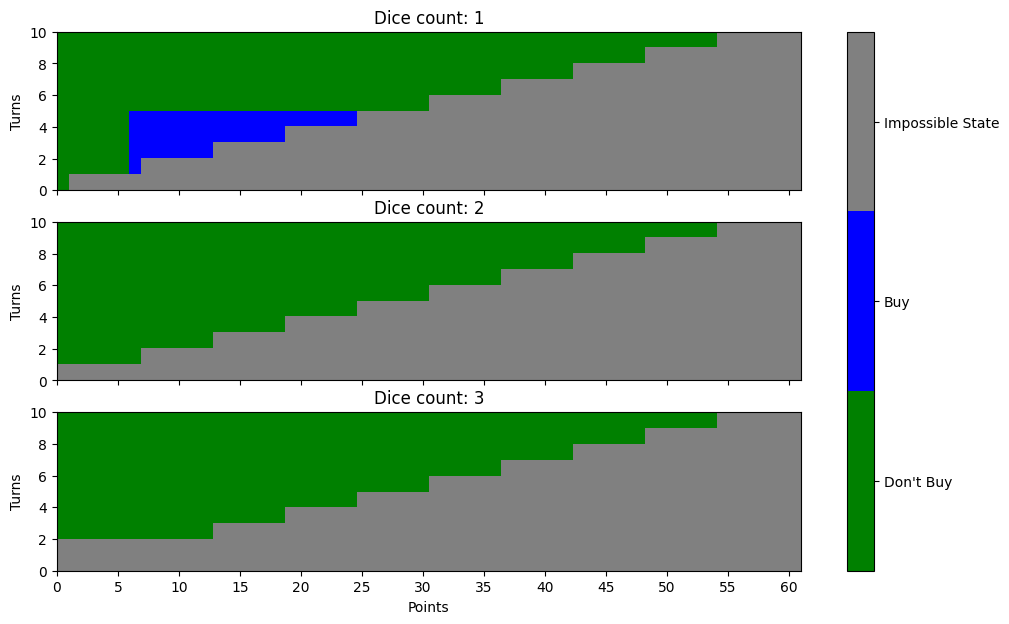

In [5]:
#Prints Optimal Strategy
def print_dice_strategy(strategy):
    T, max_points, max_dice = strategy.shape
    action_map = {0: "Don't Buy", 1: "Buy"}
    format_string = "Score={:<2}-> {:<10}"
    for t in range(T):
        print(f"\nTurn {t + 1}:")
        for dice in range(0, max_dice):
            # Display line for each dice count
            print(f"{dice+1} dice:", end=' ')
            for points in range(max_points + 1):
                if (t == 0 and dice+1 > 1) or (t == 1 and dice+1 > 2) or points > t * 6:
                    action = "Impo"
                    continue
                else:
                    action = action_map[strategy[t, points, dice]]
                print(format_string.format(points, action), end=', ')
            print()

print("Recall that:\n- Scores are those before rolling the dice(s) at turn t (that's why score=1 is impossible for Turn 1).\n- Actions are after rolling at turn t.")
print_dice_strategy(optimal_strategy)

#More advanced Visualization of strategy
from matplotlib.colors import ListedColormap
def plot_dice_strategy(strategy):
    T, max_points, max_dice = strategy.shape
    # Setup figure
    fig, axes = plt.subplots(nrows=max_dice, ncols=1, figsize=(12, 4+max_dice), sharex=True)
    cmap = ListedColormap(['green', 'blue', 'gray'])  # Don't Buy, Buy, Impossible
    for dice in range(max_dice):
        data = np.full((T, max_points + 1), 2)
        for t in range(T):
            for points in range(max_points + 1):
                if (t == 0 and dice > 0) or (t == 1 and dice > 1) or points > t * 6:
                    continue
                else:
                    data[t, points] = strategy[t, points, dice]
        im = axes[dice].imshow(data, cmap=cmap, aspect='auto', extent=[0, max_points, 0, T], origin='lower') #orgin ='lower' necessary for turns.
        axes[dice].set_title(f"Dice count: {dice + 1}")
        axes[dice].set_ylabel('Turns')
        axes[dice].label_outer()
    # Common settings
    bounds = [-0.5, 0.5, 1.5, 2.5]
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), ticks=[0, 1, 2], boundaries=bounds)
    cbar.ax.set_yticklabels(['Don\'t Buy', 'Buy', 'Impossible State'])
    plt.xlabel('Points')
    plt.xticks(range(0, max_points + 1, 5))
    plt.show()

plot_dice_strategy(optimal_strategy)

**Describe optimal strategy in simple terms** <br>
- According to the optimal strategy we found, it is never optimal to buy a dice when already having two (or 3, but here it's impossible). <br>
- Let's note that this can be specific to T = 10 (cf. code for question (1-h) where this attitude changes for T=15).
- When having **one single dice and being in turn t in [1,5] with a certain range of score (not a high score)**, it is optimal to buy a dice. <br>
Evidently, it always says "Don't buy" when it's the last turn

###Questions 1-f, 1-g and 1-h

In [ ]:
# Question (1-f)  #simulation
simul_opt_score, opt_confidence_interval = simulate_game(optimal_strategy, M=30000)
print(f"Simulated Optimal score: {simul_opt_score:.2f}", ", with a CI:", opt_confidence_interval)
print(f"Do we find the same optimal value (±0.5% error)? \n--> {'YES :)' if np.isclose(V[0,0,0], simul_opt_score, rtol=0.005) else 'NO :('}")   #Check if it's the same

Simulated Optimal score: 37.61 , with a CI: ['37.56', '37.67']
Do we find the same optimal value (±0.5% error)? 
--> YES :)


**Question (1-g)**:
- Given that each die costs 5 points and the game spans over T turns, buying a die **becomes less appealing as T decreases** because there will be fewer opportunities to utilize the die to gain points.

 When a die is bought, the player expects to increase his points by the maximum value rolled with the dices they have. For a single dice, this is on **average 3.5** (expected value of a die roll). If a player buys additional dice early, they can utilize them for more turns, increasing the potential cumulative return.<br>
For each die bought, the expected increase per turn (assuming the player rolls all owned dice) is **about 0.5 to 1 point** per turn as the maximum value of the dice rolls increases with more dice. <br>
 ⇒ As showed by plots below, for short horizons, **6 turns or less, it's never worth buying any dice** because the player wouldn't have enough turns to accumulate enough additional points from dice **to outweigh the initial cost of 5 points**. <br>

Optimal Score for 7 turns: 24.64
Simulated Optimal score: 24.59 , with a CI: ['24.52', '24.65']


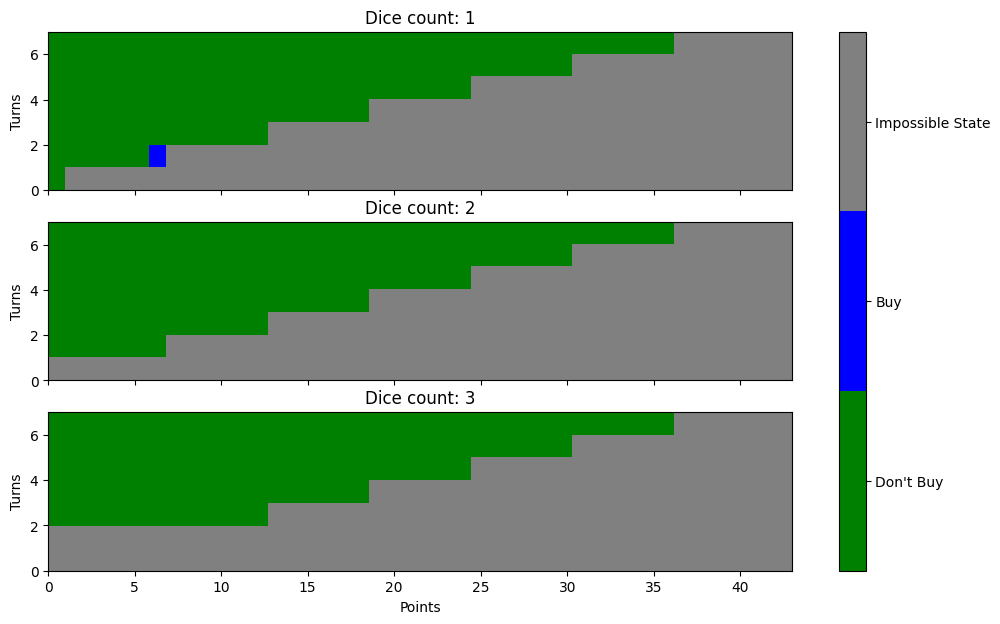

Optimal Score for 6 turns: 21.00
Simulated Optimal score: 21.04 , with a CI: ['20.98', '21.10']


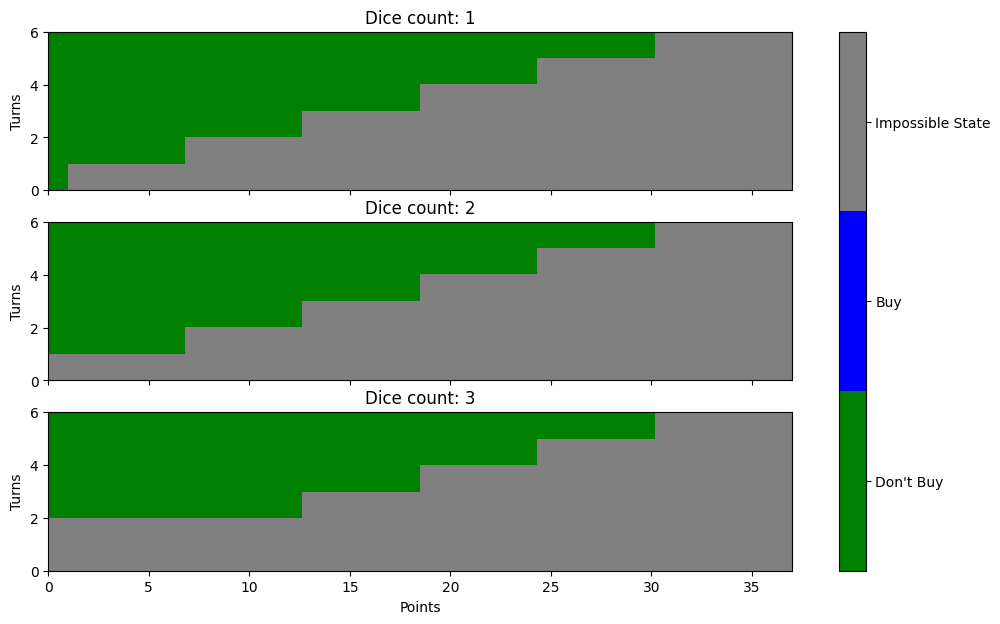

In [ ]:
# Question (1-g)
for T in [7,6]:
    V_g, optimal_strategy_g = dynamic_programming(T)
    print(f"Optimal Score for {T} turns: {V_g[0,0,0]:.2f}")
    simul_score_g, CI_g = simulate_game(optimal_strategy_g, M=20000)
    print(f"Simulated Optimal score: {simul_score_g:.2f}", ", with a CI:", CI_g)
    plot_dice_strategy(optimal_strategy_g)

**Question (1-h)**:
- If we don't restrict the maximum number of dice, some potential strategy changes would be:
 -  Player might choose to invest more in dice in the early turns to maximize the potential maximum roll in later turns, **especially in longer games**( * ). This could increase the expected points as the game progresses.
 - **The code below** (for T=20 ( * )), **does confirm the 1st reflexion**. Indeed, we have new 'buy' decisions (in blue) for states with dice_count=3.

 P.S : <br>
  - What we find strange is that the optimal score is the same for the two games (depends only on T). Despite the change in strategy. <br>
  We confirmed these scores with simulations.
  - Further, the intuitive behaviour when there are no restrictions on the max Nbr of dice **is only observed for relatively long games**.

Optimal Score for 20 turns and a maximum number of dice 3: 85.41


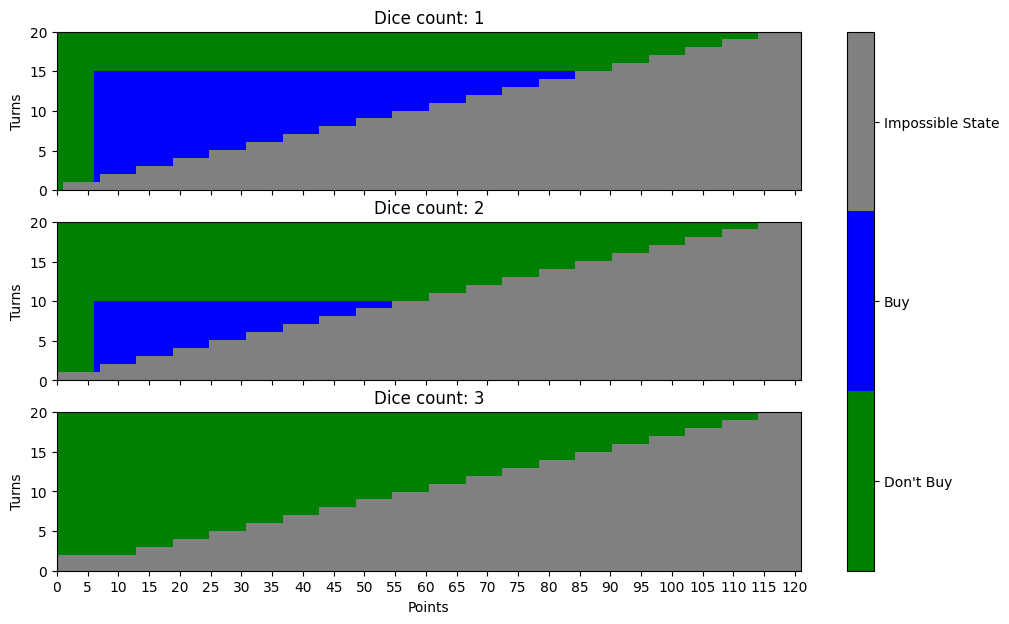

Optimal Score for 20 turns and a maximum number of dice 20: 85.41


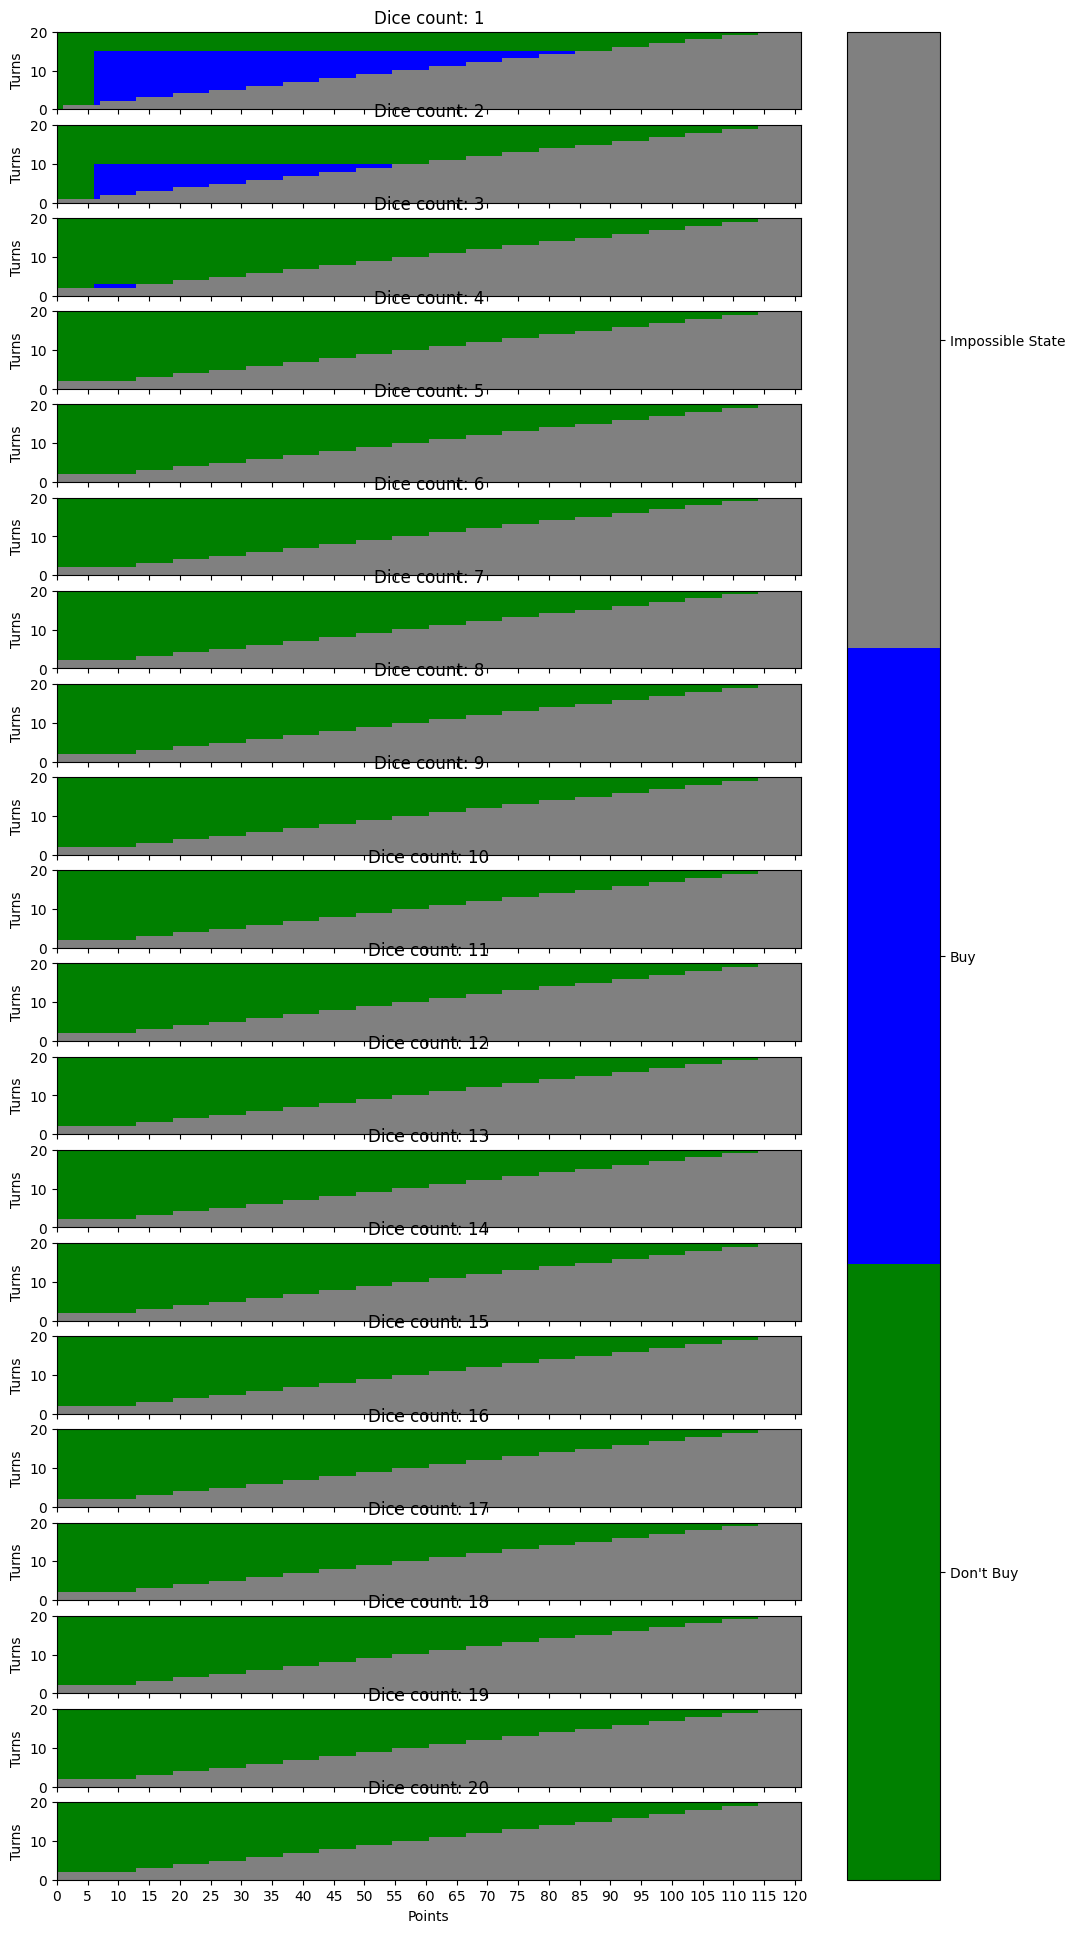

In [ ]:
# Question (1-h)
T = 20
for max_dice in [3,20]: # max_dice = 15 <--> max_dice = +infini (for T=15)
    V_h, optimal_strategy_h = dynamic_programming(T, max_dice)
    print(f"Optimal Score for {T} turns and a maximum number of dices {max_dice}: {V_h[0,0,0]:.2f}")
    plot_dice_strategy(optimal_strategy_h)

### 5 - **Spending dice**

In our approach, at the start of the turn :
 - You decide to buy a dice or not (if possible).
 - You roll the dice and take the max.
 - You decide to spend a dice or not if possible, **without seeing the roll** (as if you decided before).
 - You add the associated reward to your score given your action and roll.

In [12]:
#Question (a)

def extended_expected_score(t, points, proba_dist, Vtplus1, spend=False):  #dice_count just before the roll (i.e after decision buy or not)
    """Computes the extended expected score considering the option to spend a die."""
    expected_value = 0
    if spend:    #roll and spend
        for roll in range(1, 7):
            doubled_points = points + 2*roll   # double the throw
            # if doubled_points < len(Vtplus1):
            expected_value += proba_dist[roll-1] * Vtplus1[doubled_points]
    else:
        for roll in range(1, 7):   #no spend
            expected_value += proba_dist[roll-1] * Vtplus1[points + roll]
    return expected_value

def Q_values_extended(t, points, dice, V, max_dice):
    """Computes the Q-values for all possible actions at a state, including spending a die."""
    nbr_dice = dice + 1  # indexing
    # Calculate Q value for not buying and not spending
    Q_no_buy_no_spend = extended_expected_score(t, points, max_dice_proba(nbr_dice), V[t+1, :, dice])

    # Calculate Q value for buying a die (without spending after)
    Q_buy = -float('inf')
    if points >= 6 and nbr_dice < max_dice:
        Q_buy = extended_expected_score(t, points-5, max_dice_proba(nbr_dice+1), V[t+1, :, dice+1])

    # Calculate Q value for spending a die (without buying before))
    Q_spend = -float('inf')
    if nbr_dice > 1:
        Q_spend = extended_expected_score(t, points, max_dice_proba(nbr_dice), V[t+1, :, dice-1], spend=True)

    # Calculate Q value for buying a die (before throw) and spending it (after throw)
    Q_buy_spend = -float('inf')
    if nbr_dice > 1 and points >= 6 and nbr_dice < max_dice:
        Q_buy_spend = extended_expected_score(t, points-5, max_dice_proba(nbr_dice+1), V[t+1, :, dice+1-1], spend=True)   #Buy&Spend -> V[t+1, :, dice] but with max_dice_proba(nbr_dice+1);

    return np.array([Q_no_buy_no_spend, Q_buy, Q_spend, Q_buy_spend])


def dynamic_programming_extended(T=10, max_dice=5):
    max_dice = min(max_dice, T)  # Only one dice per turn --> max(dice_count) = T
    max_points = 6 + (T-1)*12  # Considering double points by spending a die
    V = np.zeros((T+1, max_points+1, max_dice))
    strategy = np.zeros((T, max_points+1, max_dice), dtype=int)   #0-->do nothing , 1-->just buy, 2-->just spend, 3-->buy & then spend

    # Initialization for the last turn (after it)
    for points in range(max_points+1):
        for dice in range(max_dice):
            V[T, points, dice] = points
    # Backward filling
    for t in reversed(range(T)):
        for points in range(max_points+1):
            if (t>0 and (points>6+(T-2)*12)) or (t==0 and points>max_points-12):  #ignoring some impossible states (not all)
                continue
            # maximize
            for dice in range(max_dice):
                Q_values = Q_values_extended(t, points, dice, V, max_dice)   #[Q_nothing, Q_buy, Q_spend, Q_buy_spend]
                action_ind, value = np.argmax(Q_values), np.max(Q_values)
                V[t, points, dice] = value
                strategy[t, points, dice] = action_ind

    return V, strategy

# Run extended dynamic programming
V_extended, optimal_strategy_extended = dynamic_programming_extended(T=10, max_dice=5)
print(f"Optimal Score with Spending Option: {V_extended[0,0,0]:.2f}")

Optimal Score with Spending Option: 46.97


 - Optimal value increases which is intuitive as this problem is an extension of the previous (wider action space) and thus the optimal strategy of the previous problem is sub-optimal for this one.

[Impossible state,  Do Nothing,  Buy,  Spend,  Buy&Spend] ---> [Violet,  Bleu clair,  Bleu foncé,  Vert,  Jaune]



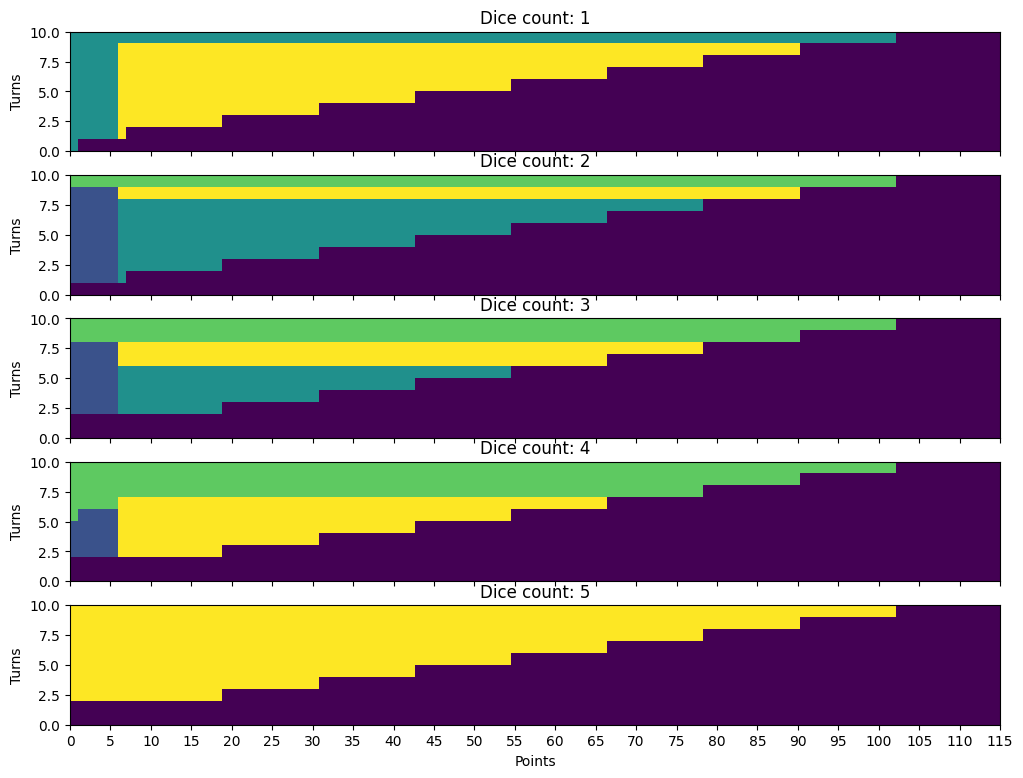

In [6]:
# Visualizing strategy
from matplotlib.colors import ListedColormap
def plot_dice_strategy(strategy):
    T, max_points, max_dice = strategy.shape
    # Setup figure
    fig, axes = plt.subplots(nrows=max_dice, ncols=1, figsize=(12, 4+max_dice), sharex=True)
    for dice in range(max_dice):
        data = np.full((T, max_points + 1), -1)  #fill with (-1) impossible states
        for t in range(T):
            for points in range(max_points + 1):
                if (t == 0 and (dice>0 or points>0)) or (t == 1 and dice > 1) or (t>0 and (points > 6+(t-1)*12)):
                    continue
                else:
                    if points>max_points-1:
                        print(t, points)
                    data[t, points] = strategy[t, points, dice]
        im = axes[dice].imshow(data, aspect='auto', extent=[0, max_points, 0, T], origin='lower') #orgin ='lower' necessary for turns.
        axes[dice].set_title(f"Dice count: {dice + 1}")
        axes[dice].set_ylabel('Turns')
        axes[dice].label_outer()
    plt.xlabel('Points')
    plt.xticks(range(0, max_points + 1, 5))
    plt.show()

print("[Impossible state,  Do Nothing,  Buy,  Spend,  Buy&Spend] ---> [Violet,  Bleu clair,  Bleu foncé,  Vert,  Jaune]\n")
plot_dice_strategy(optimal_strategy_extended)

**Description**
- A dominant optimal action is to **buy** a die before rolling then **spend a die** to double the outcome of the roll. It's seems that in many situations, especially when having 5 dice (see color yellow), this action brings a lot of points. Let's also highlight that this action is also usually legitimate as buying a die will make it possible to spend one.
- The action **Just spend** appears to be optimal only for **late turns** because which is very **intuitive** we would like to double the throw and loose a die because we won't need it a lot as the game will soon finish.

[Impossible state,  Do Nothing,  Buy,  Spend,  Buy&Spend] ---> [Violet,  Bleu clair,  Bleu foncé,  Vert,  Jaune]



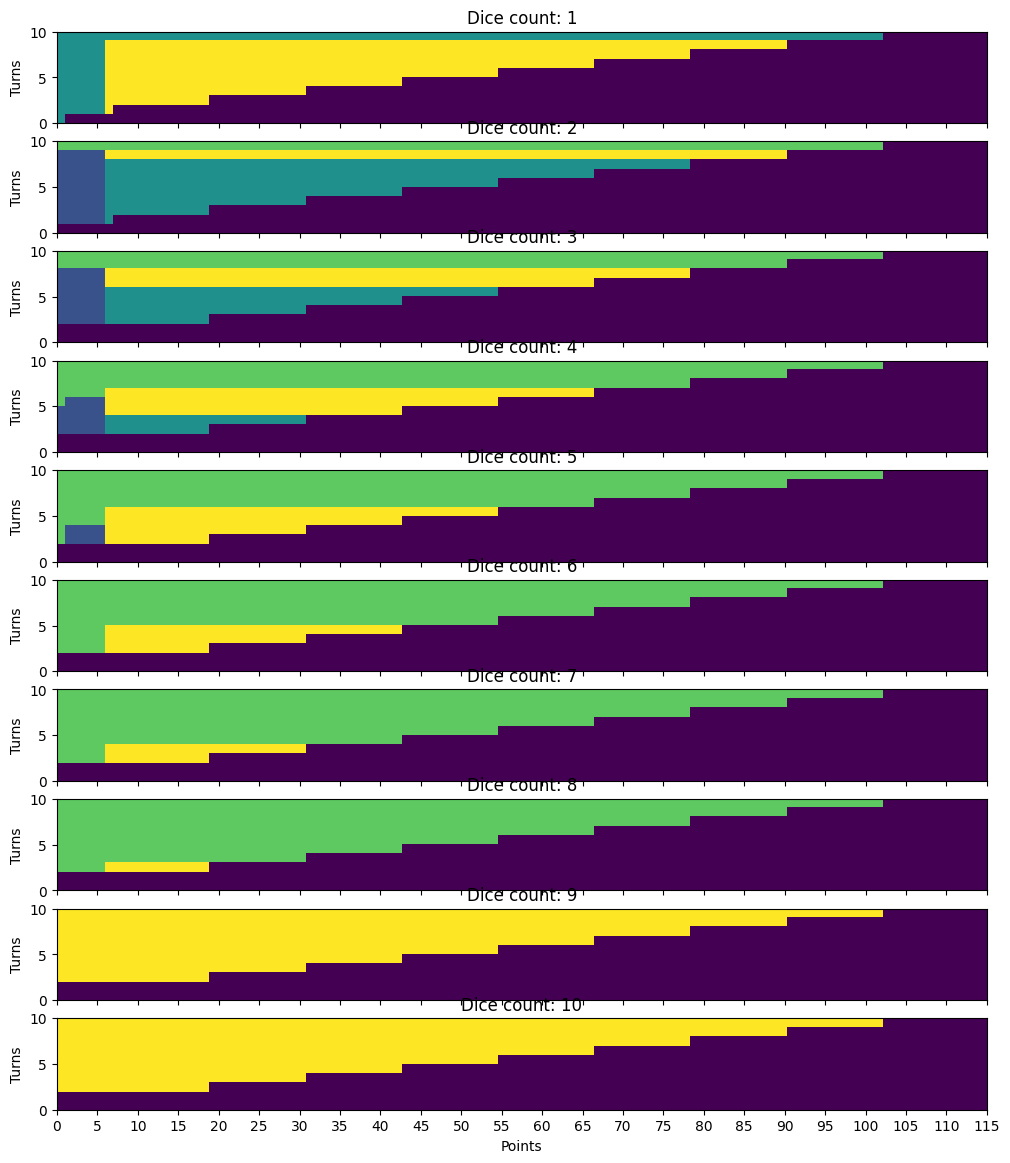

In [24]:
# Question (b)
_, optimal_strategy_extended_b = dynamic_programming_extended(T=10, max_dice=10)
print("[Impossible state,  Do Nothing,  Buy,  Spend,  Buy&Spend] ---> [Violet,  Bleu clair,  Bleu foncé,  Vert,  Jaune]\n")
plot_dice_strategy(optimal_strategy_extended_b)

→ We don't find much more **just buy** decisions. However we see a lot of **buy then spend** decisions, which are possibly be encouraged by the fact that there are no restrictions on the number of dices. The number of **just spend** decisions rises also (advanced turns).

In [19]:
#Question (c)

def Q_values_extended_c(t, points, dice, V, max_dice, T):
    """Computes the Q-values for all possible actions at a state, including spending a die."""
    nbr_dice = dice + 1  # indexing
    if t==T-1:
        dice = 0
        nbr_dice = 1
    # Calculate Q value for not buying and not spending
    Q_no_buy_no_spend = extended_expected_score(t, points, max_dice_proba(nbr_dice), V[t+1, :, dice])

    # Calculate Q value for buying a die (without spending after)
    Q_buy = -float('inf')
    if points >= 6 and nbr_dice < max_dice:
        Q_buy = extended_expected_score(t, points-5, max_dice_proba(nbr_dice+1), V[t+1, :, dice+1])

    # Calculate Q value for spending a die (without buying before))
    Q_spend = -float('inf')
    if nbr_dice > 1:
        Q_spend = extended_expected_score(t, points, max_dice_proba(nbr_dice), V[t+1, :, dice-1], spend=True)

    # Calculate Q value for buying a die (before throw) and spending it (after throw)
    Q_buy_spend = -float('inf')
    if nbr_dice > 1 and points >= 6 and nbr_dice < max_dice:
        Q_buy_spend = extended_expected_score(t, points-5, max_dice_proba(nbr_dice+1), V[t+1, :, dice], spend=True)   #Buy&Spend -> V[t+1, :, dice] but with max_dice_proba(nbr_dice+1);

    return np.array([Q_no_buy_no_spend, Q_buy, Q_spend, Q_buy_spend])


def dynamic_programming_extended_c(T=10, max_dice=5):
    K = [0,2,4,5,8]   #additional points at the end
    max_dice = min(max_dice, T)  # Only one dice per turn --> max(dice_count) = T
    max_points = 6 + (T-1)*12  # Considering double points by spending a die
    V = np.zeros((T+1, max_points+1, max_dice))
    strategy = np.zeros((T, max_points+1, max_dice), dtype=int)   #0-->do nothing , 1-->just buy, 2-->just spend, 3-->buy & then spend

    # Initialization for the last turn (after it)
    for points in range(6+(T-2)*12 +1):
        for dice in range(max_dice):
            V[T, points, dice] = points + K[dice]
    # Backward filling
    for t in reversed(range(T)):
        for points in range(max_points+1):
            if (t>0 and (points>6+(t-1)*12)) or (t==0 and points>max_points-12):  #impossible states (let values = 0)
                continue
            # maximize
            for dice in range(max_dice):
                Q_values = Q_values_extended_c(t, points, dice, V, max_dice, T)   #[Q_nothing, Q_buy, Q_spend, Q_buy_spend]
                action_ind, value = np.argmax(Q_values), np.max(Q_values)
                V[t, points, dice] = value
                strategy[t, points, dice] = action_ind

    return V, strategy

# Run extended dynamic programming
V_extended_c, optimal_strategy_extended_c = dynamic_programming_extended_c(T=10, max_dice=5)
print(f"Optimal Score with Spending Option and Selling dices: {V_extended_c[0,0,0]:.2f}")

Optimal Score with Spending Option and Selling dices: 44.73


 - **Optimal Strategy Shifts**: The new optimal score might reflect a shift towards strategies that more carefully consider when to buy or spend dice, especially as the game nears completion. \\
 Player might be choosing to conserve dice for sale rather than spending them on potentially risky rolls that don't guarantee a higher final score.

 - **Question (d)** : <br>
  As all dice are sold, the 2nd player will have to play a T=10 game but starting with a score = final score of 1st player.
 → We should choose K values equal to the expected final score of the 1st player if **he starts with a score roughly = (optimal value for T=10)**, i.e  $V_0[\text{Opt_score, 0}]$, and an intial number of dice ~ average final number of dices for the optimal strategy (T=10). <br>
 Thus we are assuming that when playing a T=20 game, we will behave in the first 10 turns in an optimal way i.e equivalently to when playing a game of T=10.<br>

- **Question (e)** : With this idea we can approximate $10^{10}$ turns game with a smaller game of $10^{10}$/2 turns by chosing K-values as explained before. Then approximate this one similarily. Until having a solvable game. The more the approximations, the less optimal the obtained results are.

In [27]:
# Test Q(e)
V_extended_e, optimal_strategy_extended_e = dynamic_programming_extended_c(T=20)
print(f"Optimal Score with Spending Option and Selling dices for T=20: {V_extended_e[0,0,0]:.2f}")
V_e, optimal_strategy_e = dynamic_programming_extended(T=10)
print("We think that the average number of dice in the last turn of a 10-turn optimal game is close to 2.")
print(f"Optimal Score for T=10 starting with a score of 45 and 2 dice: {V_e[0,45,1]:.2f}.")

Optimal Score with Spending Option and Selling dices for T=20 and max_dice=5: 103.18
We think that the average number of dice in the last turn of a 10-turn optimal game is close to 2.
Optimal Score for T=10 starting with a score of 45 and 2 dice: 103.61.
